In [52]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Directory containing the audio recordings
directory = 'C:/Users/Josep/Downloads/Compressed/speech dataset/recordings'

# Load audio recordings and create labels
X = []
y = []

# Define a function to calculate MFCC
def calculate_mfcc(audio, sr, n_mfcc):
    # Apply pre-emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=emphasized_signal, sr=sr, n_mfcc=n_mfcc)
    return mfcc

for file_name in os.listdir(directory):
    file_path = os.path.join(directory, file_name)
    audio, sr = librosa.load(file_path)
    mfcc = calculate_mfcc(audio, sr, n_mfcc=20)
    X.append(mfcc)
    label = int(file_name.split('_')[0])
    y.append(label)

# Pad the audio recordings to have the same length
max_length = max(mfcc.shape[1] for mfcc in X)
X = [np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1]))) for mfcc in X]

# Convert lists to numpy arrays
X = np.array(X)
# Normalize MFCCs to have zero mean and unit variance
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = np.array(y)

# Convert labels to categorical format
y = to_categorical(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Continue with the model construction
input_shape = X_train.shape[1:]
input_layer = Input(shape=input_shape)
conv1 = Conv1D(32, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
bn1 = BatchNormalization()(conv1)
conv2 = Conv1D(64, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.01))(bn1)
bn2 = BatchNormalization()(conv2)

# Flattening the output from the convolutional layers
flattened = Flatten()(bn2)

# Dropout regularization
dropout = Dropout(0.86)(flattened)

# Output layer
num_labels = 10  # Number of labels (numbers from 0 to 9)
output_layer = Dense(num_labels, activation='softmax')(dropout)

# Constructing the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=100, callbacks=[es])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Printing the loss and accuracy
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/100
38/38 [==============================] - 6s 87ms/step - loss: 5.1102 - categorical_accuracy: 0.2138 - val_loss: 2.7236 - val_categorical_accuracy: 0.5600
Epoch 2/100
38/38 [==============================] - 3s 76ms/step - loss: 3.4629 - categorical_accuracy: 0.3854 - val_loss: 2.2603 - val_categorical_accuracy: 0.7567
Epoch 3/100
38/38 [==============================] - 3s 66ms/step - loss: 2.8716 - categorical_accuracy: 0.5054 - val_loss: 1.8935 - val_categorical_accuracy: 0.8433
Epoch 4/100
38/38 [==============================] - 3s 75ms/step - loss: 2.4847 - categorical_accuracy: 0.6012 - val_loss: 1.6324 - val_categorical_accuracy: 0.8833
Epoch 5/100
38/38 [==============================] - 3s 75ms/step - loss: 2.1453 - categorical_accuracy: 0.6463 - val_loss: 1.4719 - val_categorical_accuracy: 0.9033
Epoch 6/100
38/38 [==============================] - 3s 80ms/step - loss: 1.7994 - categorical_accuracy: 0.7050 - val_loss: 1.3402 - val_categorical_accuracy: 0.9067
Epoc

In [58]:
# Let's evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Predicting on the test set
y_pred = model.predict(X_test)

# Since the output is one-hot encoded, we'll convert predictions and true values back to label form for comparison
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

# Let's see the first 10 predictions
for i in range(10):
    print(f"True: {y_test_label[i]}, Predicted: {y_pred_label[i]}")

19/19 [==============================] - 0s 8ms/step - loss: 0.3632 - categorical_accuracy: 0.9650
Loss: 0.363189697265625
Accuracy: 0.9649999737739563
19/19 [==============================] - 0s 5ms/step
True: 6, Predicted: 6
True: 3, Predicted: 3
True: 6, Predicted: 6
True: 0, Predicted: 0
True: 8, Predicted: 8
True: 3, Predicted: 3
True: 4, Predicted: 4
True: 7, Predicted: 7
True: 1, Predicted: 1
True: 8, Predicted: 8


In [59]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Convert y_train back to original label format
y_train_label = np.argmax(y_train, axis=1)

# Fit the LabelEncoder with training labels
le = LabelEncoder()
le.fit(y_train_label)

# Convert predictions and true values back to label form for comparison
y_pred_label = le.inverse_transform(np.argmax(y_pred, axis=1))
y_test_label = le.inverse_transform(np.argmax(y_test, axis=1))

# Calculate classification metrics
report = classification_report(y_test_label, y_pred_label)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.99      0.97      0.98        69
           2       1.00      0.93      0.96        57
           3       0.93      0.96      0.95        56
           4       1.00      0.97      0.98        59
           5       0.98      0.97      0.98        63
           6       0.86      1.00      0.93        56
           7       0.98      0.96      0.97        55
           8       1.00      0.91      0.95        57
           9       0.92      0.98      0.95        56

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.97       600



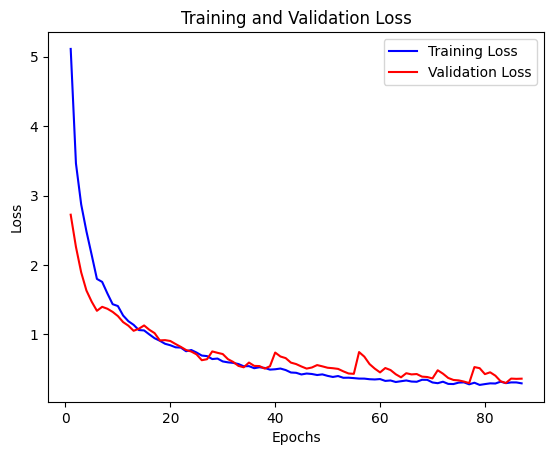

In [60]:
import matplotlib.pyplot as plt

# Access the loss values from the history object
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot the loss values
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

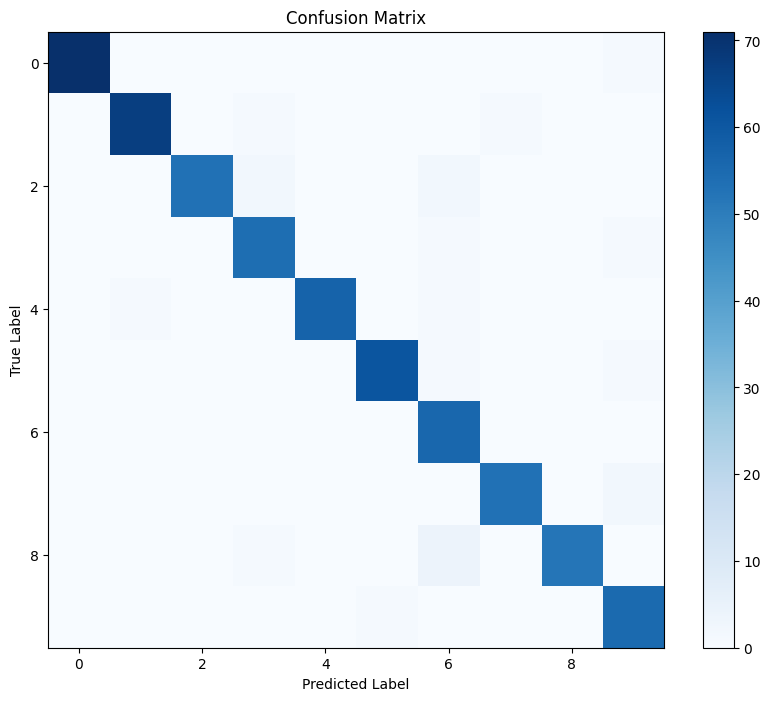

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test_label, y_pred_label)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

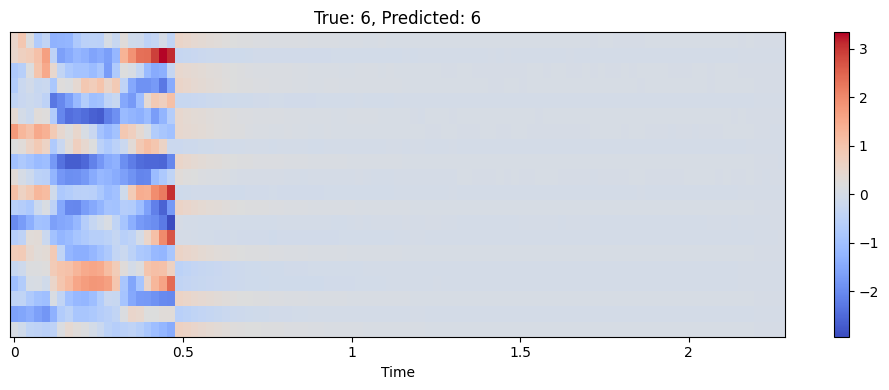

In [62]:
import matplotlib.pyplot as plt
# Choose an index from the test set
index = 0

# Get the true label and the predicted label
true_label = y_test_label[index]
predicted_label = y_pred_label[index]

# Get the corresponding MFCCs
mfccs = X_test[index]

# Display them
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title(f'True: {true_label}, Predicted: {predicted_label}')
plt.tight_layout()
plt.show()